In [26]:
# Imports
import shutil
import subprocess
from Bio import SeqIO
from Bio import Phylo
import matplotlib as mpl
import matplotlib.pyplot as plt

In [27]:
def generate_raxml_tree(sample, seed):
    # Define the paths for the input fasta file and the output tree name
    input_file = "data/fasta/aligned/" + sample + "_aligned.fasta"
    output_tree_name = sample + "_raxml_tree"

    # Define the RAxML command as a traditional string
    cmd = "raxmlHPC -f a -s " + input_file + " -n " + output_tree_name + " -m GTRGAMMA -p "+ seed + " -x 1 -# 100"

    # Run the RAxML command
    result = subprocess.run(cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Move the generated RAxML output files to the specified directory
    shutil.move("RAxML_bestTree." + output_tree_name, "data/raxml_tree/RAxML_bestTree." + output_tree_name)
    shutil.move("RAxML_bootstrap." + output_tree_name, "data/raxml_tree/RAxML_bootstrap." + output_tree_name)
    shutil.move("RAxML_bipartitions." + output_tree_name, "data/raxml_tree/RAxML_bipartitions." + output_tree_name)
    shutil.move("RAxML_bipartitionsBranchLabels." + output_tree_name, "data/raxml_tree/RAxML_bipartitionsBranchLabels." + output_tree_name)
    shutil.move("RAxML_info." + output_tree_name, "data/raxml_tree/RAxML_info." + output_tree_name)

In [28]:
def get_haplotype_frequency(sample):
    # Initialize dictionaries to store unique haplotypes and their frequencies
    unique_haplotypes = {}
    haplotype_frequencies = {}
    
    # Flag to identify if we are within the "Haplotype frequencies" section in the file
    is_in_haplotype_section = False

    # Open and read the file
    with open("data/" + sample + "/HaROLD/step_2/" + sample + ".log", "r") as file:
        lines = file.readlines()
        for line in lines:
            # Strip the line to remove leading and trailing whitespaces
            stripped_line = line.strip()
            
            # If we encounter the "Haplotype frequencies" line, set the flag to True
            if 'Haplotype frequencies' in stripped_line:
                is_in_haplotype_section = True
                continue

            # If we're inside the "Haplotype frequencies" section and we encounter 
            # a blank line or a line starting with a non-digit, break out of the loop
            if is_in_haplotype_section and (stripped_line == "" or not stripped_line[0].isdigit()):
                break

            # If we're inside the "Haplotype frequencies" section, extract key-value pairs and update the dictionary
            if is_in_haplotype_section:
                key, value = stripped_line.split()
                # Convert the string value to float after replacing comma with period
                haplotype_frequencies[sample + "_H" + str(key)] = round((float(value.replace(',', '.')) * 100), 1)

    # Return the final dictionary of haplotype frequencies
    return haplotype_frequencies

In [36]:
def draw_phylogenetic_tree_figure(samples, baby_haplotypes, mother_haplotypes, haplotype_frequencies):
    # Set the figure parameters
    figure_width = 9
    figure_height = 6
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(2 * figure_width, 4 * figure_height))

    # For each sample draw a tree
    for sample_name, ax in zip(samples, axes.ravel()):
        # Read and draw the tree
        tree = Phylo.read(f"data/raxml_tree/RAxML_bipartitions.{sample_name}_raxml_tree", "newick")
        Phylo.draw(tree, axes=ax, label_func=lambda x: str(x)[:], do_show=False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f"Family {sample_name[0:2]}", fontsize=12, weight='bold')
        
        # Modify the leaf labels
        for text in ax.texts:
            haplotype_name = text.get_text().strip()
            
            # Modify the Merlin reference strain label
            if haplotype_name == "ul33_Merlin_seq": 
                text.set_text("Merlin")
                text.set_color("tab:red")
                text.set_weight('bold')

            # Modify the AD169 reference strain label
            elif haplotype_name == "HCMV_AD169_UL33": 
                text.set_text("AD169")
                text.set_color("tab:blue")
                text.set_weight('bold')

            # Modify the Toledo reference strain label
            elif haplotype_name == "HCMV_Toledo_UL33": 
                text.set_text("Toledo")
                text.set_color("tab:purple")
                text.set_weight('bold')

            # Modify the Towne reference strain label
            elif haplotype_name == "HCMV_Towne_UL33": 
                text.set_text("Towne")
                text.set_color("tab:brown")
                text.set_weight('bold')
                
            else:
                # Modify the mother haplotype most likely to be transmitted
                if haplotype_name in mother_haplotypes:
                    text.set_color("tab:orange")
                    text.set_weight('bold')
                    
                # Modify the majority baby haplotype
                elif haplotype_name in baby_haplotypes:
                    text.set_color("tab:green")
                    text.set_weight('bold')

                # Update label with haplotype frequencies if available
                try: text.set_text(f" {haplotype_name[3:-6]}.{haplotype_name[-2:]} ({haplotype_frequencies[haplotype_name]}%)")
                except KeyError: pass

    # Create and add a legend
    red_line = plt.Line2D([0], [0], color='tab:red', lw=4, label='UL33 Merlin strain')
    blue_line = plt.Line2D([0], [0], color='tab:blue', lw=4, label='UL33 AD169 strain')
    purple_line = plt.Line2D([0], [0], color='tab:purple', lw=4, label='UL33 Toledo strain')
    brown_line = plt.Line2D([0], [0], color='tab:brown', lw=4, label='UL33 Towne strain')
    green_line = plt.Line2D([0], [0], color='tab:green', lw=4, label='Majority baby haplotype')
    orange_line = plt.Line2D([0], [0], color='tab:orange', lw=4, label='Mother haplotype most likely to be transmitted')
    
    # Add the legend to the figure
    fig.legend(handles=[red_line, blue_line, purple_line, brown_line, green_line, orange_line], loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol=6, fontsize='large') 
    
    # Ensure that subplots fit within the figure area without overlapping
    plt.tight_layout()
    # Save the plot
    plt.savefig("fig/figure_phylogenetic_trees_families.pdf", format='pdf', dpi=300, bbox_inches='tight')
    # Display the plot
    plt.show()

In [43]:
# Define a list of sample
samples = ["04.B1.W14.01_04.M1.W09.02", "05.B1.W14.04_05.M1.W08.03", "27.B1.W13.06_27.M1.W10.07",
           "30.B1.W11.08_30.M1.W04.09", "38.B1.W10.11_38.M1.W03.10", "39.B1.W11.12_39.M1.W03.13_39.M1.W05.14",
           "53.B1.W14.17_53.M1.W07.16", "56.B1.W09.22_56.M1.W03.21", "63.B1.W09.29_63.M1.W02.30", 
           "66.B1.W09.25_66.M1.W02.24"]
# Define the seed (doesn't really change the result but rather improves the visualization of the tree)
seeds = ["2", "4", "1", "2", "3", "2", "2", "1", "1", "1"]

# For each sample generate a RAxML tree
for i, sample in enumerate(samples): 
    generate_raxml_tree(sample, seeds[i])

In [44]:
# Initialize a dictionary to store the haplotype frequencies across all samples
haplotype_frequencies = {}

# Define a list of sample names for which haplotype frequencies need to be computed
samples = ["04.B1.W14.01", "04.M1.W09.02", "05.B1.W14.04", "05.M1.W08.03", "27.B1.W13.06", "27.M1.W10.07",
           "30.B1.W11.08", "30.M1.W04.09", "38.B1.W10.11", "38.M1.W03.10", "39.B1.W11.12", "39.M1.W03.13", 
           "39.M1.W05.14", "53.B1.W14.17", "53.M1.W07.16", "56.B1.W09.22", "56.M1.W03.21", "63.B1.W09.29", 
           "63.M1.W02.30", "66.B1.W09.25", "66.M1.W02.24"]

# Loop over each sample in the list
for sample in samples:
    # Call the 'get_frequencies' function for the sample and update the global haplotype_frequencies dictionary with the frequencies for this sample
    haplotype_frequencies = {**haplotype_frequencies, **get_haplotype_frequency(sample)}

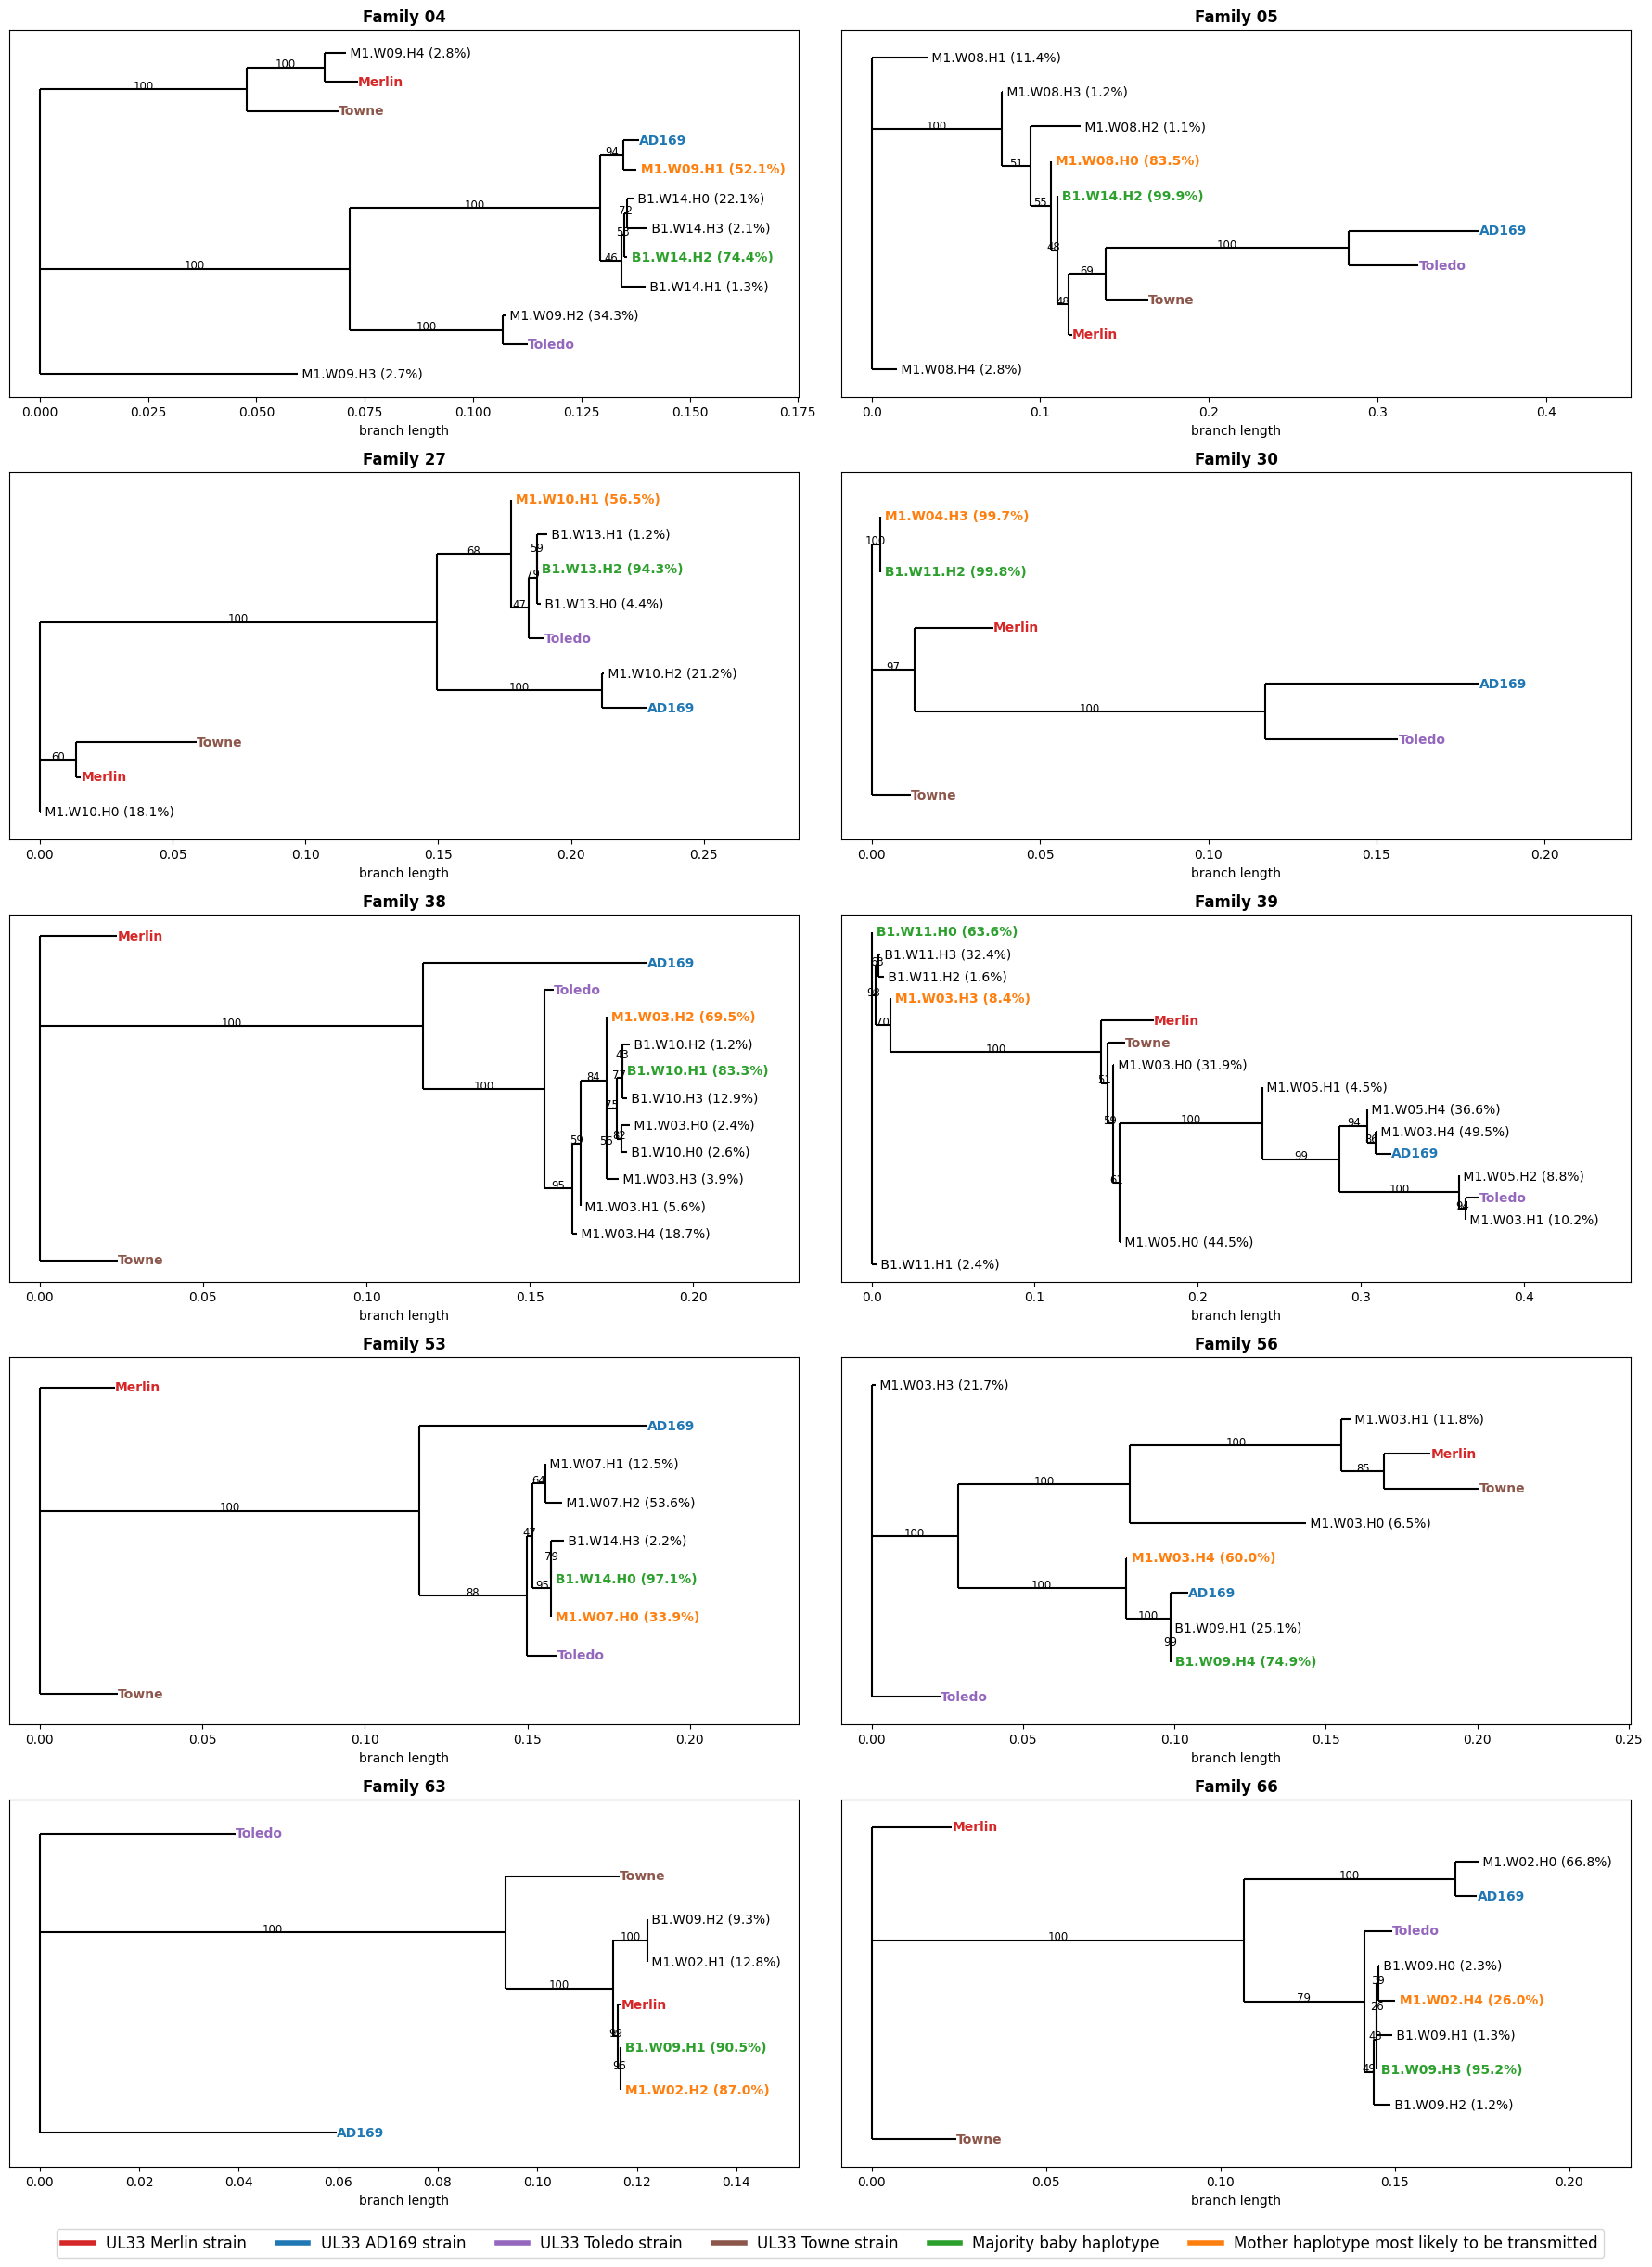

In [47]:
# Define a list of sample to include in the figure
samples = ["04.B1.W14.01_04.M1.W09.02", "05.B1.W14.04_05.M1.W08.03", 
           "27.B1.W13.06_27.M1.W10.07", "30.B1.W11.08_30.M1.W04.09", 
           "38.B1.W10.11_38.M1.W03.10", "39.B1.W11.12_39.M1.W03.13_39.M1.W05.14",
           "53.B1.W14.17_53.M1.W07.16", "56.B1.W09.22_56.M1.W03.21", 
           "63.B1.W09.29_63.M1.W02.30", "66.B1.W09.25_66.M1.W02.24"]

# Define a list of baby haplotypes to highlight 
baby_haplotypes = ["04.B1.W14.01_H2", "05.B1.W14.04_H2", "27.B1.W13.06_H2", "30.B1.W11.08_H2",
                  "38.B1.W10.11_H1", "39.B1.W11.12_H0", "53.B1.W14.17_H0", "56.B1.W09.22_H4", 
                  "63.B1.W09.29_H1", "66.B1.W09.25_H3"]

# Define a list of mother haplotypes to highlight 
mother_haplotypes = ["04.M1.W09.02_H1", "05.M1.W08.03_H0", "27.M1.W10.07_H1", "30.M1.W04.09_H3",
                     "38.M1.W03.10_H2", "39.M1.W03.13_H3", "53.M1.W07.16_H0", "56.M1.W03.21_H4",
                     "63.M1.W02.30_H2", "66.M1.W02.24_H4"]

# Draw the phylogenetic tree figure
draw_phylogenetic_tree_figure(samples, baby_haplotypes, mother_haplotypes, haplotype_frequencies)